# Join plots for models

Join in one graph the plots for all p

In [1]:
import sys
sys.path.append('C:\\Users\\MHJGuillermo\\PycharmProjects\\Doctorado\\Ising\\Varios_vecinos\\venv\\src')

In [2]:
%pylab inline

from pathlib import Path

import h5py
import numpy as np
import style
from ising.io import read_ising_config
from matplotlib import pyplot, rcParams
from matplotlib.axes import Axes, GridSpec
from matplotlib.figure import Figure
from ruamel.yaml import YAML
from scipy import interpolate as interp
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
import pandas as pd
import json

import os
import re

yaml = YAML()

Populating the interactive namespace from numpy and matplotlib


## Model

In [3]:
def model_function(x: float,a1: float,a2: float,a3: float):
    return a1*((x+a2)**2 + a3)

def get_extrapol_function(model_function,a1,a2,a3):
    def extrapol_funct(x):
        return model_function(x,a1,a2,a3)
    return extrapol_funct


## Get data

In [4]:
data_path = Path("../../../data/").resolve()
file_all_tc = 'all_inv_Tc.csv'
df_inv_all_tc = pd.read_csv(os.path.join(data_path,file_all_tc))
file_params = "inv_Tc_vs_inv_nv_extrapol_hiperbolic_3_parms_with_nv-1_v2_params_curves.csv"
df_params = pd.read_csv(os.path.join(data_path,"Extrapolation",file_params),index_col=0)

In [5]:
df_params

,P1.0,P1.1,P1.2,P1.3,P1.4,P1.5,P1.6,P1.7,P1.8,P1.9,P2.0
a1,1.012410,0.974891,0.944109,0.905901,0.874160,0.849650,0.830021,0.817832,0.812333,0.810098,0.814598
a2,0.183657,0.232290,0.273758,0.330655,0.378498,0.412367,0.435399,0.438182,0.422461,0.396684,0.353171
a3,-0.013367,-0.021286,-0.023905,-0.033458,-0.033501,-0.017312,0.014837,0.071470,0.148411,0.236479,0.334445


0.9446331111739458 , 0.0 , 0.5135560764823112


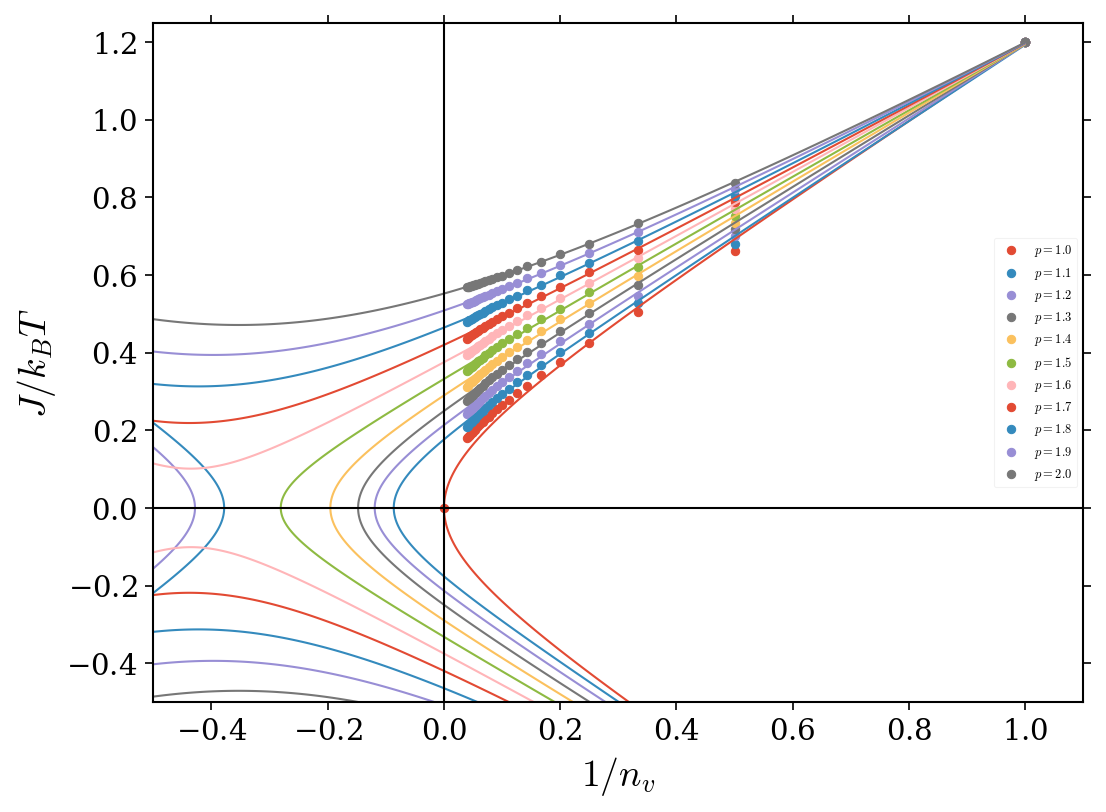

In [10]:
columns = ["P1.0","P1.1","P1.2","P1.3","P1.4","P1.5","P1.6","P1.7","P1.8","P1.9","P2.0"]

# Load the default style.
style.use("default")
rcParams["text.usetex"] = False

fig1: Figure = pyplot.figure(figsize=(8, 6), dpi=150)
grid_spec = GridSpec(1, 1)

# Specific heat subplot.
ax: Axes = fig1.add_subplot(grid_spec[0, 0])


for index,column in enumerate(columns):
    # Get inv_tc per col
    y_data_all = df_inv_all_tc.loc[:, column]

    x_data = np.array(df_inv_all_tc.loc[y_data_all.notnull(), "1/nv"])
    y_data = np.array(y_data_all.loc[y_data_all.notnull()])
    
    # add value at nv=1
    x_data = np.concatenate([x_data,[1]])
    y_data = np.concatenate([y_data,[1.19968]])
        
    # get params
    # fit with (0,0)
    if column == 'P1.0':
        file_params_with_cero = "square_inv_Tc_vs_inv_nv_extrapol_parabolic_2_parms_with_cero_and_one_params_curves.csv"
        df_params_with_cero = pd.read_csv(os.path.join(data_path,"Extrapolation",file_params_with_cero),index_col=0)
        (a1,a2,a3) = df_params_with_cero[column].values
        print(a1,',',a2,',',a3)
        
        #add value at nv=infty
        x_data = np.insert(x_data,0,0)
        y_data = np.insert(y_data,0,0)
        
        #add value at nv=1
        x_data = np.insert(x_data,0,1)
        y_data = np.insert(y_data,0,1.19968)
        
        # Contour fit
        x_data_fine = np.linspace(-1, 1, num=1024)
        y_data_fine = np.linspace(-1, 1.2, num=1024)
        x_data_mat, y_data_mat = np.meshgrid(x_data_fine, y_data_fine, sparse=True)
        z_data_mat = a1*(x_data_mat**2 + a3*x_data_mat)-y_data_mat**2
        # adjust for MA
#         z_data_mat = (0.900823**2)*(x_data_mat**2 + 2*x_data_mat*(0.354213))-y_data_mat**2

        ax.contour(x_data_fine, y_data_fine, z_data_mat, levels=[0],colors=['C'+str(index)])

        ax.scatter(x_data, y_data, marker="o", color='C'+str(index), label = '$p=1.0$')

    else:
        (a1,a2,a3) = df_params[column].values

    #     # get model
    #     extrapol_funct = get_extrapol_function(model_function, a1, a2, a3)

    #     # define the point for graph
    #     x_extrapol = np.linspace(-1, 1, 2048)
    #     y_extrapol = extrapol_funct(x_extrapol)

        #add value at nv=1
        x_data = np.insert(x_data,0,1)
        y_data = np.insert(y_data,0,1.19968)

        # Contour fit
        x_data_fine = np.linspace(-1, 1, num=1024)
        y_data_fine = np.linspace(-1, 1.2, num=1024)
        x_data_mat, y_data_mat = np.meshgrid(x_data_fine, y_data_fine, sparse=True)
        z_data_mat = (a1**2)*((x_data_mat+a2)**2+a3)-y_data_mat**2

        ax.contour(x_data_fine,
                   y_data_fine,
                   z_data_mat,
                   levels=[0],
                   colors=['C'+str(index)]
                  )

        if index == 10:
            ax.scatter(x_data, y_data, marker="o", color='C'+str(index),label = '$p=2.0$')
        else:
            ax.scatter(x_data, y_data, marker="o", color='C'+str(index),label = '$p=1.{}$'.format(index))

ax.set_xlabel(r"$1 / n_v$")
ax.set_ylabel(r"$J / k_B T$")

ax.set_ylim(-0.5, 1.25)
ax.set_xlim(-0.5, 1.1)

# ax.set_ylim(0, 0.6)
# ax.set_xlim(0, 0.2)

ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')
ax.legend(
    #('$p=1.0$','$p=1.1$','$p=1.2$','$p=1.3$','$p=1.4$','$p=1.5$','$p=1.6$','$p=1.7$','$p=1.8$','$p=1.9$','$p=2.0$'),
          loc ="center right")
# ax.set_xscale("log")
# ax.set_yscale("log")

pyplot.draw()
pyplot.show()

In [29]:
df_params_with_cero

,P1.0
infty,0.000000
1,1.111886
